<a href="https://colab.research.google.com/github/JihyeLimm/Quest/blob/main/Going_Deeper_NLP/node6/gd_node6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#6. 뉴스 카테고리 다중분류 [프로젝트] - Vocabulary Size 변경
1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?
>3가지 단어 개수(모든단어, 빈도수 상위 5000, 직접 설정)에 대해 8가지 머신러닝 기법(나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅)을 적용하여 그중 최적의 솔루션을 도출하였다.
2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?
>Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.
3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?
>동일한 데이터셋과 전처리 조건으로 딥러닝 모델(RNN이나 1-D CNN 등)의 성능과 비교하여 결과에 따른 원인을 분석하였다.

#1. 분류모델 accuracy확인

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.initializers import Constant
from tensorflow.keras.datasets import reuters
from keras.utils import pad_sequences
from keras.layers import Input, Embedding, GRU, Dense
from keras.models import Model

import matplotlib.pyplot as plt
import seaborn
import numpy as np
import pandas as pd
import random
import sklearn


import urllib.request
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

데이터 다운로드


In [2]:
#num_words = [None, 5000, 10000]
(x_train_N, y_train_N), (x_test_N, y_test_N) = reuters.load_data(num_words=None, test_split=0.2)
(x_train_5, y_train_5), (x_test_5, y_test_5) = reuters.load_data(num_words=5000, test_split=0.2)
(x_train_1, y_train_1), (x_test_1, y_test_1) = reuters.load_data(num_words=1000, test_split=0.2)

print('훈련 샘플의 수: {}'.format(len(x_train_N)))   #8982
print('테스트 샘플의 수: {}'.format(len(x_test_N)))  #2246

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [3]:
#'단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = { index+3 : word for word, index in word_index.items() }

#index_to_word에 <pad>, <sos>, <unk> 토큰 추가
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

print("n_words = None: " + ' '.join([index_to_word[index] for index in x_train_N[0]]))
print("n_words = 5000: " + ' '.join([index_to_word[index] for index in x_train_5[0]]))
print("n_words = 1000: " + ' '.join([index_to_word[index] for index in x_train_1[0]]))

n_words = None: <sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
n_words = 5000: <sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
n_words = 1000: <sos> <unk> <unk> said as a result of its december acquisition of <unk> co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share

In [4]:
print(index_to_word[0])
print(index_to_word[1])
print(index_to_word[2])

<pad>
<sos>
<unk>


데이터 전처리

In [5]:
#전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환
def ind_tex(x_train, x_test):
  decoded = []
  for i in range(len(x_train)):
      t = ' '.join([index_to_word[index] for index in x_train[i]])
      decoded.append(t)

  x_train = decoded

  decoded = []
  for i in range(len(x_test)):
      t = ' '.join([index_to_word[index] for index in x_test[i]])
      decoded.append(t)

  x_test = decoded

  return x_train, x_test

x_train_N, x_test_N = ind_tex(x_train_N, x_test_N)
x_train_5, x_test_5 = ind_tex(x_train_5, x_test_5)
x_train_1, x_test_1 = ind_tex(x_train_1, x_test_1)
print(len(x_train_1))  #8982
print(len(x_test_1))   #2246

8982
2246


벡터화하기

In [6]:
def dtm_tfidf(x_train, x_test):
  dtmvector = CountVectorizer() #Document Term Matrix, DTM
  tfidf_transformer = TfidfTransformer()  #DTM을 TF-IDF 행렬로 변환

  #train_data
  x_train_dtm = dtmvector.fit_transform(x_train)
  tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)

  #test data
  x_test_dtm = dtmvector.transform(x_test)
  tfidfv_test = tfidf_transformer.transform(x_test_dtm)
  return tfidfv_train, tfidfv_test


tfidfv_N, tfidfv_t_N = dtm_tfidf(x_train_N, x_test_N)
tfidfv_5, tfidfv_t_5 = dtm_tfidf(x_train_5, x_test_5)
tfidfv_1, tfidfv_t_1 = dtm_tfidf(x_train_1, x_test_1)

print(tfidfv_N.shape, tfidfv_t_N.shape)   #(8982, 26506) (2246, 26506)
print(tfidfv_5.shape, tfidfv_t_5.shape)   #(8982, 4867) (2246, 4867)
print(tfidfv_1.shape, tfidfv_t_1.shape)   #(8982, 969) (2246, 969)

(8982, 26506) (2246, 26506)
(8982, 4867) (2246, 4867)
(8982, 969) (2246, 969)


8가지 머신러닝 기법

In [7]:
#method = [nb, cnb, lr, lsvc, tree, forest, grbt, voting]
#tfidfv_train = [tfidfv_N, tfidfv_5, tfidfv_1]
#tfidfv_test = [tfidfv_t_N, tfidfv_t_5, tfidfv_t_1]

def machine(method, tfidfv_train, y_train, tfidfv_test, y_test):
    if method == "nb":
        model = MultinomialNB()
    elif method == "cnb":
        model = ComplementNB()
    elif method == "lr":
        model = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
    elif method == "lsvc":
        model = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
    elif method == "tree":
        model = DecisionTreeClassifier(max_depth=10, random_state=0)
    elif method == "forest":
        model = RandomForestClassifier(n_estimators=5, random_state=0)
    elif method == "grbt":
        model = GradientBoostingClassifier(random_state=0)
    elif method == "voting":
        lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
        cb = ComplementNB()
        grbt = GradientBoostingClassifier(random_state=0)
        model = VotingClassifier(estimators=[('lr', lr), ('cb', cb), ('grbt', grbt)], voting='soft', verbose=1)
    else:
        raise ValueError("Invalid method")

    model.fit(tfidfv_train, y_train)
    predicted = model.predict(tfidfv_test)
    return method, accuracy_score(y_test, predicted)

1. 나이브베이즈 분류기

In [ ]:
#num_words=1000
print("1000: ", machine("nb", tfidfv_1, y_train_1, tfidfv_t_1, y_test_1))
#num_words=5000
print("5000: ", machine("nb", tfidfv_5, y_train_5, tfidfv_t_5, y_test_5))
#num_words=None
print("None: ", machine("nb", tfidfv_N, y_train_N, tfidfv_t_N, y_test_N))

1000:  ('nb', 0.6856634016028496)
5000:  ('nb', 0.6731967943009796)
None:  ('nb', 0.5997328584149599)


2. Complement Naive Bayes Classifier(CNB)

In [ ]:
print("1000: ", machine("cnb", tfidfv_1, y_train_1, tfidfv_t_1, y_test_1))
print("5000: ", machine("cnb", tfidfv_5, y_train_5, tfidfv_t_5, y_test_5))
print("None: ", machine("cnb", tfidfv_N, y_train_N, tfidfv_t_N, y_test_N))

1000:  ('cnb', 0.7346393588601959)
5000:  ('cnb', 0.7707034728406055)
None:  ('cnb', 0.7649154051647373)


3. 로지스틱 회귀(Logistic Regression)

In [ ]:
print("1000: ", machine("lr", tfidfv_1, y_train_1, tfidfv_t_1, y_test_1))
print("5000: ", machine("lr", tfidfv_5, y_train_5, tfidfv_t_5, y_test_5))
print("None: ", machine("lr", tfidfv_N, y_train_N, tfidfv_t_N, y_test_N))

1000:  ('lr', 0.738646482635797)
5000:  ('lr', 0.8032056990204809)
None:  ('lr', 0.8161175422974176)


4. 선형 서포트 벡터 머신(Linear Support Vector Machine)

In [40]:
print("1000: ", machine("lsvc", tfidfv_1, y_train_1, tfidfv_t_1, y_test_1))
print("5000: ", machine("lsvc", tfidfv_5, y_train_5, tfidfv_t_5, y_test_5))
print("None: ", machine("lsvc", tfidfv_N, y_train_N, tfidfv_t_N, y_test_N))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1000:  ('lsvc', 0.723953695458593)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


5000:  ('lsvc', 0.7689225289403384)
None:  ('lsvc', 0.7920747996438112)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


5. 결정 트리(Decision Tree)

In [41]:
print("1000: ", machine("tree", tfidfv_1, y_train_1, tfidfv_t_1, y_test_1))
print("5000: ", machine("tree", tfidfv_5, y_train_5, tfidfv_t_5, y_test_5))
print("None: ", machine("tree", tfidfv_N, y_train_N, tfidfv_t_N, y_test_N))

1000:  ('tree', 0.6179875333926982)
5000:  ('tree', 0.6179875333926982)
None:  ('tree', 0.6211041852181657)


6. 랜덤 포레스트(Random Forest)

In [42]:
print("1000: ", machine("forest", tfidfv_1, y_train_1, tfidfv_t_1, y_test_1))
print("5000: ", machine("forest", tfidfv_5, y_train_5, tfidfv_t_5, y_test_5))
print("None: ", machine("forest", tfidfv_N, y_train_N, tfidfv_t_N, y_test_N))

1000:  ('forest', 0.707479964381122)
5000:  ('forest', 0.701246660730187)
None:  ('forest', 0.6544968833481746)


7. 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [45]:
print("1000: ", machine("grbt", tfidfv_1, y_train_1, tfidfv_t_1, y_test_1))
print("5000: ", machine("grbt", tfidfv_5, y_train_5, tfidfv_t_5, y_test_5))
print("None: ", machine("grbt", tfidfv_N, y_train_N, tfidfv_t_N, y_test_N))

1000:  ('grbt', 0.7453250222617988)
5000:  ('grbt', 0.767586821015138)
None:  ('grbt', 0.7702582368655387)


8. 소프트보팅

In [8]:
print("1000: ", machine("voting", tfidfv_1, y_train_1, tfidfv_t_1, y_test_1))
print("5000: ", machine("voting", tfidfv_5, y_train_5, tfidfv_t_5, y_test_5))
print("None: ", machine("voting", tfidfv_N, y_train_N, tfidfv_t_N, y_test_N))

[Voting] ....................... (1 of 3) Processing lr, total= 6.4min
[Voting] ....................... (2 of 3) Processing cb, total=   0.1s
[Voting] ..................... (3 of 3) Processing grbt, total=14.0min
1000:  ('voting', 0.7644701691896705)
[Voting] ....................... (1 of 3) Processing lr, total= 6.6min
[Voting] ....................... (2 of 3) Processing cb, total=   0.1s
[Voting] ..................... (3 of 3) Processing grbt, total=17.5min
5000:  ('voting', 0.8103294746215495)
[Voting] ....................... (1 of 3) Processing lr, total=11.4min
[Voting] ....................... (2 of 3) Processing cb, total=   0.1s
[Voting] ..................... (3 of 3) Processing grbt, total=19.3min
None:  ('voting', 0.8156723063223509)


#2. 분류 모델의 F1 score

In [ ]:
# 정밀도, 재현율, F1점수를 구하는 classification_report() 함수
#("None: ", machine("lr", tfidfv_N, y_train_N, tfidfv_t_N, y_test_N)) : 최고성능달성
model = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
model.fit(tfidfv_N, y_train_N)
print(classification_report(y_test_N, model.predict(tfidfv_t_N), zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.75      0.79      0.77       105
           2       0.78      0.70      0.74        20
           3       0.92      0.93      0.93       813
           4       0.81      0.88      0.84       474
           5       1.00      0.20      0.33         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.71      0.71      0.71        38
           9       0.85      0.88      0.86        25
          10       0.93      0.90      0.92        30
          11       0.67      0.72      0.70        83
          12       0.57      0.31      0.40        13
          13       0.64      0.62      0.63        37
          14       0.67      1.00      0.80         2
          15       0.80      0.44      0.57         9
          16       0.70      0.77      0.73        99
          17       0.82    

#3. 딥러닝 모델RNN과 성능비교

In [11]:
#데이터 로드
(x_train_d, y_train_d), (x_test_d, y_test_d) = reuters.load_data(num_words=5000, test_split=0.2)

print('훈련 샘플의 수: {}'.format(len(x_train_d)))   #8982
print('테스트 샘플의 수: {}'.format(len(x_test_d)))  #2246

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


문장의 최단 길이: 13
문장의 최장 길이: 2376
문장의 평균 길이: 145


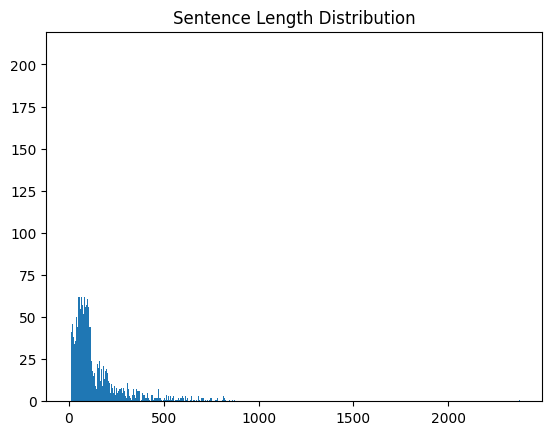

In [12]:
#최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이 분포를 막대그래프로 표현
min_len = 999
max_len = 0
sum_len = 0

for sen in x_train_d:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(x_train_d))

sentence_length = np.zeros((max_len), dtype=int)

for sen in x_train_d:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [13]:
#패딩 추가
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train_d,
                                                        value=0,
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=400)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test_d,
                                                       value=0,
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=400)

print(x_train.shape)  #(8982, 400)
print(x_test.shape)   #(2246, 400)

(8982, 400)
(2246, 400)


In [14]:
#Validation set 구성
x_val = x_train[:1000]
y_val = y_train_d[:1000]

partial_x_train = x_train[1000:]
partial_y_train = y_train_d[1000:]

print(len(partial_x_train))
print(len(x_val))

7982
1000


In [15]:
vocab_size = 5000
word_vector_dim = 100

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, word_vector_dim)(inputs)
x = layers.LSTM(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(46, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         500000    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 46)                5934      
                                                                 
Total params: 623,182
Trainable params: 623,182
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#모델학습

callbacks = [keras.callbacks.EarlyStopping(monitor = "val_loss", verbose = 1, patience = 4),
             keras.callbacks.ModelCheckpoint("reuter_1522.keras",
                                             save_best_only=True)
]

model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks = callbacks)

#테스트셋으로 모델 평가
model = keras.models.load_model("reuter_1522.keras")    #("/gdrive/MyDrive/AIFFEL/230627")
print(f"테스트 accuracy: {model.evaluate(x_test, y_test_d)[1]:.2f}")

Epoch 1/20
63/63 [==============================] - 14s 184ms/step - loss: 1.0359 - accuracy: 0.7310 - val_loss: 1.4087 - val_accuracy: 0.6690
Epoch 2/20
63/63 [==============================] - 9s 145ms/step - loss: 0.9678 - accuracy: 0.7457 - val_loss: 1.4569 - val_accuracy: 0.6670
Epoch 3/20
63/63 [==============================] - 9s 142ms/step - loss: 0.8974 - accuracy: 0.7642 - val_loss: 1.3806 - val_accuracy: 0.6750
Epoch 4/20
63/63 [==============================] - 8s 122ms/step - loss: 0.8691 - accuracy: 0.7706 - val_loss: 1.4451 - val_accuracy: 0.6600
Epoch 5/20
63/63 [==============================] - 7s 113ms/step - loss: 0.8280 - accuracy: 0.7800 - val_loss: 1.4005 - val_accuracy: 0.6680
Epoch 6/20
63/63 [==============================] - 7s 104ms/step - loss: 0.7961 - accuracy: 0.7899 - val_loss: 1.3705 - val_accuracy: 0.6820
Epoch 7/20
63/63 [==============================] - 6s 99ms/step - loss: 0.7574 - accuracy: 0.8013 - val_loss: 1.4863 - val_accuracy: 0.6510
Epoch 

!보충학습
>하이퍼파라미터 튜닝(https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=ko)

In [46]:
import tensorflow as tf
from tensorflow import keras

import IPython
!pip install -q -U keras-tuner
import kerastuner as kt

def build_model(hp):
    vocab_size = 5000
    word_vector_dim = 100

    inputs = keras.Input(shape=(None,), dtype="int64")
    x = layers.Embedding(vocab_size, word_vector_dim)(inputs)

    # Tune the number of LSTM units
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    x = layers.LSTM(units=hp_units)(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(46, activation="softmax")(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='my_project')

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=4),
             keras.callbacks.ModelCheckpoint("reuter_1522.keras", save_best_only=True)
]

tuner.search(partial_x_train, partial_y_train, epochs=20, validation_data=(x_val, y_val), callbacks=callbacks)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model
history = best_model.fit(partial_x_train,
                         partial_y_train,
                         epochs=20,
                         batch_size=128,
                         validation_data=(x_val, y_val),
                         verbose=1,
                         callbacks=callbacks)

Trial 8 Complete [00h 01m 08s]
val_accuracy: 0.5889999866485596

Best val_accuracy So Far: 0.5889999866485596
Total elapsed time: 00h 09m 59s
Epoch 1/20
63/63 [==============================] - 13s 163ms/step - loss: 1.6232 - accuracy: 0.5950 - val_loss: 1.5244 - val_accuracy: 0.5980
Epoch 2/20
63/63 [==============================] - 10s 156ms/step - loss: 1.5140 - accuracy: 0.6114 - val_loss: 1.5169 - val_accuracy: 0.6100
Epoch 3/20
63/63 [==============================] - 8s 122ms/step - loss: 1.4488 - accuracy: 0.6308 - val_loss: 1.4623 - val_accuracy: 0.6290
Epoch 4/20
63/63 [==============================] - 7s 112ms/step - loss: 1.3739 - accuracy: 0.6490 - val_loss: 1.4219 - val_accuracy: 0.6360
Epoch 5/20
63/63 [==============================] - 5s 79ms/step - loss: 1.3105 - accuracy: 0.6670 - val_loss: 1.4469 - val_accuracy: 0.6240
Epoch 6/20
63/63 [==============================] - 7s 104ms/step - loss: 1.2603 - accuracy: 0.6776 - val_loss: 1.8029 - val_accuracy: 0.5580
Epoch

In [16]:
#테스트셋으로 모델 평가
model = keras.models.load_model("reuter_1522.keras")    #("/gdrive/MyDrive/AIFFEL/230627")
print(f"테스트 accuracy: {model.evaluate(x_test, y_test_d)[1]:.2f}")

71/71 [==============================] - 2s 10ms/step - loss: 1.3133 - accuracy: 0.6817
테스트 accuracy: 0.68
